# GPU & Mount Drive

> Runtime에서 GPU설정했는지 꼭 확인

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jun  8 22:42:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


# 필요한 라이브러리 

Lightly가 잘 다운로드 되었는지 꼭 확인

In [ ]:
!pip3 install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

/usr/local/lib/python3.7/dist-packages/lightly/cli/train_cli.py:145: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/usr/local/lib/python3.7/dist-packages/lightly/cli/embed_cli.py:97: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/upload_cli.py:167: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/usr/local/lib/python3.7/dist-packages/lightly/cli/lightly_cli.py:70: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability versio

# 경로 확인 및 데이터 잘 마운트 되었는지 꼭 확인.

> 가끔 RHEED폴더 안에 ipynb checkpoints가 들어가서 오류나는 경우 생김. 그러면 # 제거하고 지워주기

In [ ]:
path_to_data = '/content/drive/MyDrive/RHEED'
path_to_test = '/content/drive/MyDrive/Train'

In [ ]:
#!rm -R /content/drive/MyDrive/RHEED/.ipynb_checkpoints

# Hyperparameters

> batch_size, input_size정도만 만지기

단, 너무 resolution 높이면 메모리 에러남. 모델 돌리는데 갑자기 메모리가 부족하다는 에러 뜨면 배치 사이즈, 인풋 사이즈 줄이기

> 경험상 epochs는 50이 제일 적절한듯, 시간 남아돌면 올려보기. 보통 40분걸림.

> seed는 늘 1로 해주기

In [ ]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 50
input_size = 128
num_ftrs = 32

# 데이터로더

> 파이토치는 데이터로더로 데이터를 관리함

원래는 test, train을 따로 나누는 함수를 사용해서 나눴는데 경험상 그렇게 안해도 되는 듯, 해보다가 필요에 따라 다시 나누는 걸로 하고 일단은 test, train 둘다 같은 녀석을 사용함.

> 우리가 만질건, transform, collate_fn. 

https://docs.lightly.ai/lightly.data.html?highlight=rr#lightly.data.collate.MultiCropCollateFunction.crop_sizes

위키에서 어떤 augmentation이 있는지 잘 확인하고 돌려보기.

transform은 국룰 조합으로 진행해서 normalize했음.

> 만약 collate를 바꿨으면, 꼭 저장하는 모델, 사진 이름 바꿔서 기록 남겨주기

# Preprocessing

In [ ]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5,
    cj_prob=0.5,
    random_gray_scale=0.5
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)
dataset_test2 = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)


dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

dataloader_test2 = torch.utils.data.DataLoader(
    dataset_test2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# 모델 및 학습

In [ ]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [ ]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus, progress_bar_refresh_rate=100
)
trainer.fit(model, dataloader_train_simclr)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=100)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss     

Training: 0it [00:00, ?it/s]

# Show the Results

> 저장인지 로드인지 잘 보기

In [ ]:
torch.save(model, '/content/drive/MyDrive/model50.pt')
#model = torch.load('/content/drive/MyDrive/Model/model.pt')

In [ ]:
# for plotting
import os
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp

# for resizing images to thumbnails
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
df_li = pd.read_csv("/content/drive/MyDrive/Samples/idx_sample.csv")
shown_list = df_li['0']
shown_lists = shown_list.tolist()
type(shown_lists)

list

In [ ]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given mode
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).cpu().flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

In [ ]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

In [ ]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=7, num_examples=15):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)
    print(samples_idx)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            fig.set_size_inches(40,50)
            # let's disable the axis
            plt.axis('off')

In [ ]:
plot_knn_examples(embeddings, filenames)


Output hidden; open in https://colab.research.google.com to view.

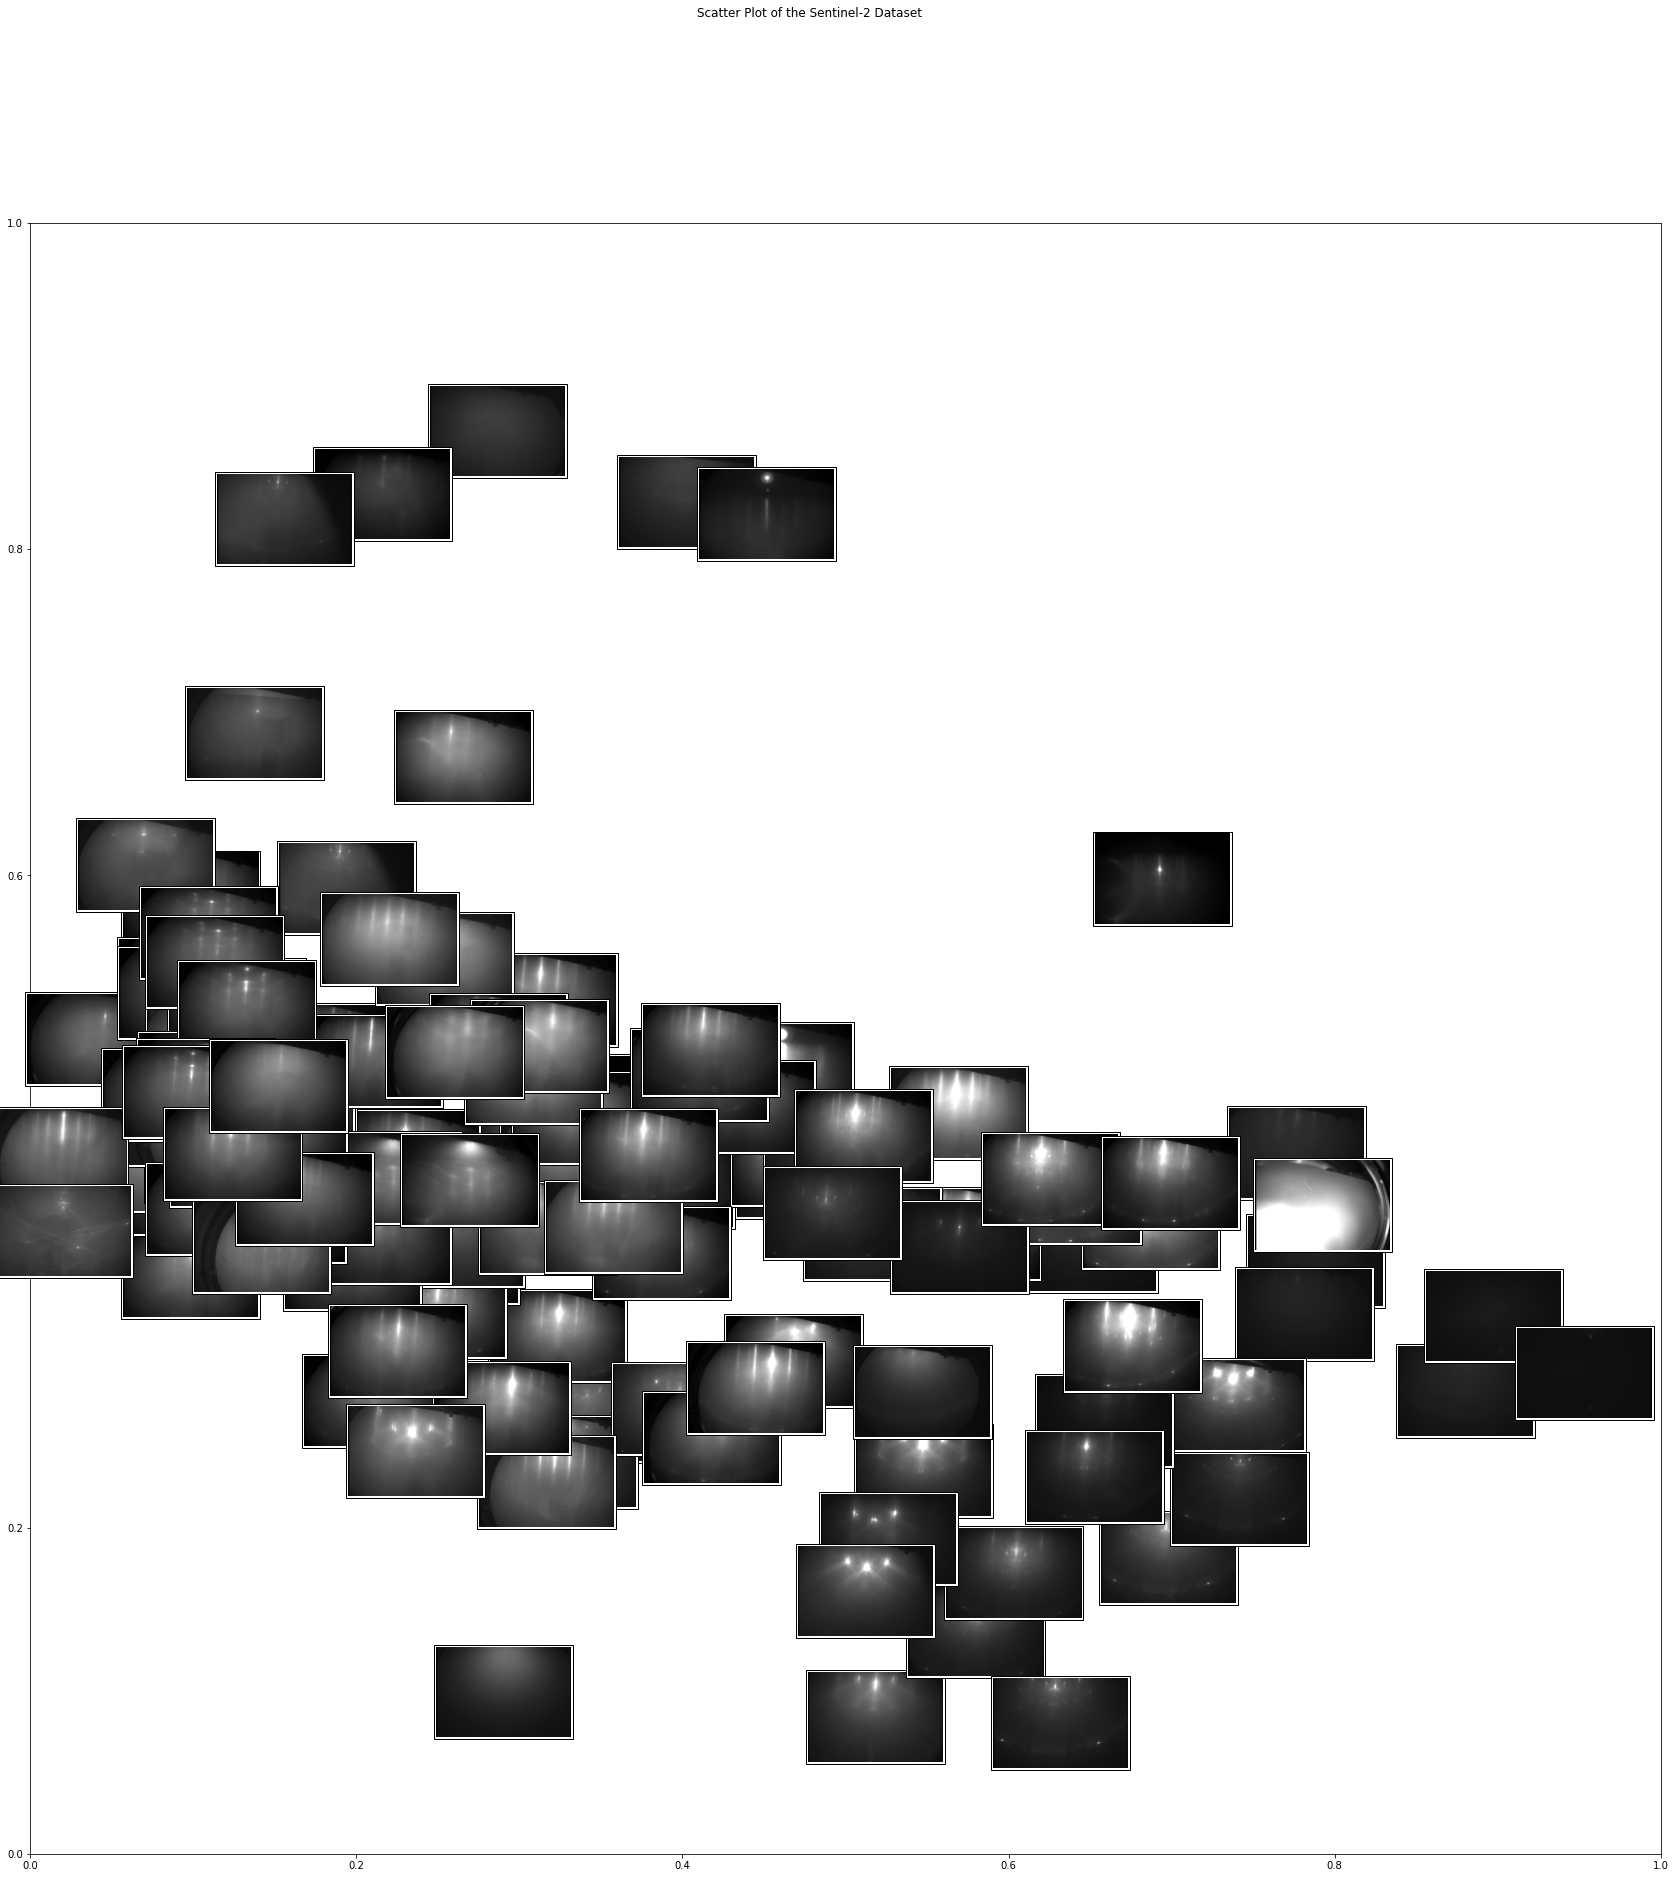

In [ ]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot

    fig = plt.figure()
    fig.set_size_inches(40,30)

    fig.suptitle('Scatter Plot of the Sentinel-2 Dataset')
    ax = fig.add_subplot(1, 1, 1)

    '''
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.seed(0)
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        #if np.min(dist) < 2e-3:
        #    continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)
    print(shown_images_idx)
    arr1 = np.array(shown_images_idx)
#    np.save('/content/drive/MyDrive/idx.csv', arr1) 

    # plot image overlays
    filenames_solution=[]

'''
    shown_images_idx = shown_lists
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 15.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)
 #       filenames_solution.append(filenames[idx])
#    print(filenames_solution)
#    arr2 = np.array(filenames_solution)
#   np.save('/content/drive/MyDrive/fname.csv', arr2) 




    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
#    plt.savefig('/content/drive/MyDrive/Figures/' + 'savefig_default2'+str(max_epochs)+'vr,rr,crop'+'.png')

# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

In [ ]:
df = pd.DataFrame(embeddings_2d, columns=['x','y'])
non=[]
non = [i for i in range(df.shape[0])]
droper=[]
droper = [x for x in non if x not in shown_lists]
df = df.drop(droper)
df = df.reset_index()
df

,index,x,y
0,10,0.389358,0.411765
1,18,0.417653,0.254911
2,33,0.312114,0.495394
3,40,0.260470,0.491445
4,41,0.156688,0.454788
...,...,...,...
127,2624,0.289002,0.273355
128,2629,0.039554,0.499700
129,2653,0.125039,0.464815
130,2663,0.472016,0.425449


In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/Samples/fname_sample - fname_sample.csv')
df2 = df2.drop(['설명: 1x1 1, 2x2 2, 3D 3, poly 4, 그래핀합성전 5, 그래핀6, 그래핀-1x1 7, 1x1 broad 8, flat substrate 9, dot 10, Broad 11'],axis=1)
df2

,Fname,Label,1순서
0,0103_15시43분_Video_1.jpg,1,25
1,0105_23시09분_Video700도어닐후.jpg,7,101
2,0109_19시10분_Video증착4분.jpg,3,64
3,0109_19시38분_Video증착완료.jpg,3,99
4,0109_20시15분_Video600어닐후.jpg,3,85
...,...,...,...
127,1213_18시11분_Video600도 어닐링후 250도 부ᄀ...,7,79
128,1213_19시10분_VideoSe처리2분.jpg,10,39
129,1214_19시02분_Video600도어닐후250도.jpg,8,5
130,1216_15시43분_Video.jpg,7,35


In [ ]:
df2_s = df2

In [ ]:
df2 = df2.sort_values(by=['1순서'], ascending=[True])
df2['Label'] = df2_s['Label']
df2 = df2.reset_index()
df2= df2.drop(['index'],axis=1)
df2

,Fname,Label,1순서
0,0416_14시32분_Video05.jpg,1,2
1,0707_20시28분_Video1-00.jpg,7,3
2,1101_13시34분_Video5.jpg,7,4
3,1214_19시02분_Video600도어닐후250도.jpg,8,5
4,1025_09시19분_Video 30m anneal.jpg,11,6
...,...,...,...
127,1014_21시55분_Video.jpg,9,129
128,1010_16시48분_Video.jpg,11,130
129,0126_17시52분_Video17분.jpg,7,131
130,0425_22시19분_Video07.jpg,1,132


In [ ]:
df['Label'] = df2['Label']
df

,index,x,y,Label
0,10,0.389358,0.411765,1
1,18,0.417653,0.254911,7
2,33,0.312114,0.495394,7
3,40,0.260470,0.491445,8
4,41,0.156688,0.454788,11
...,...,...,...,...
127,2624,0.289002,0.273355,9
128,2629,0.039554,0.499700,11
129,2653,0.125039,0.464815,7
130,2663,0.472016,0.425449,1


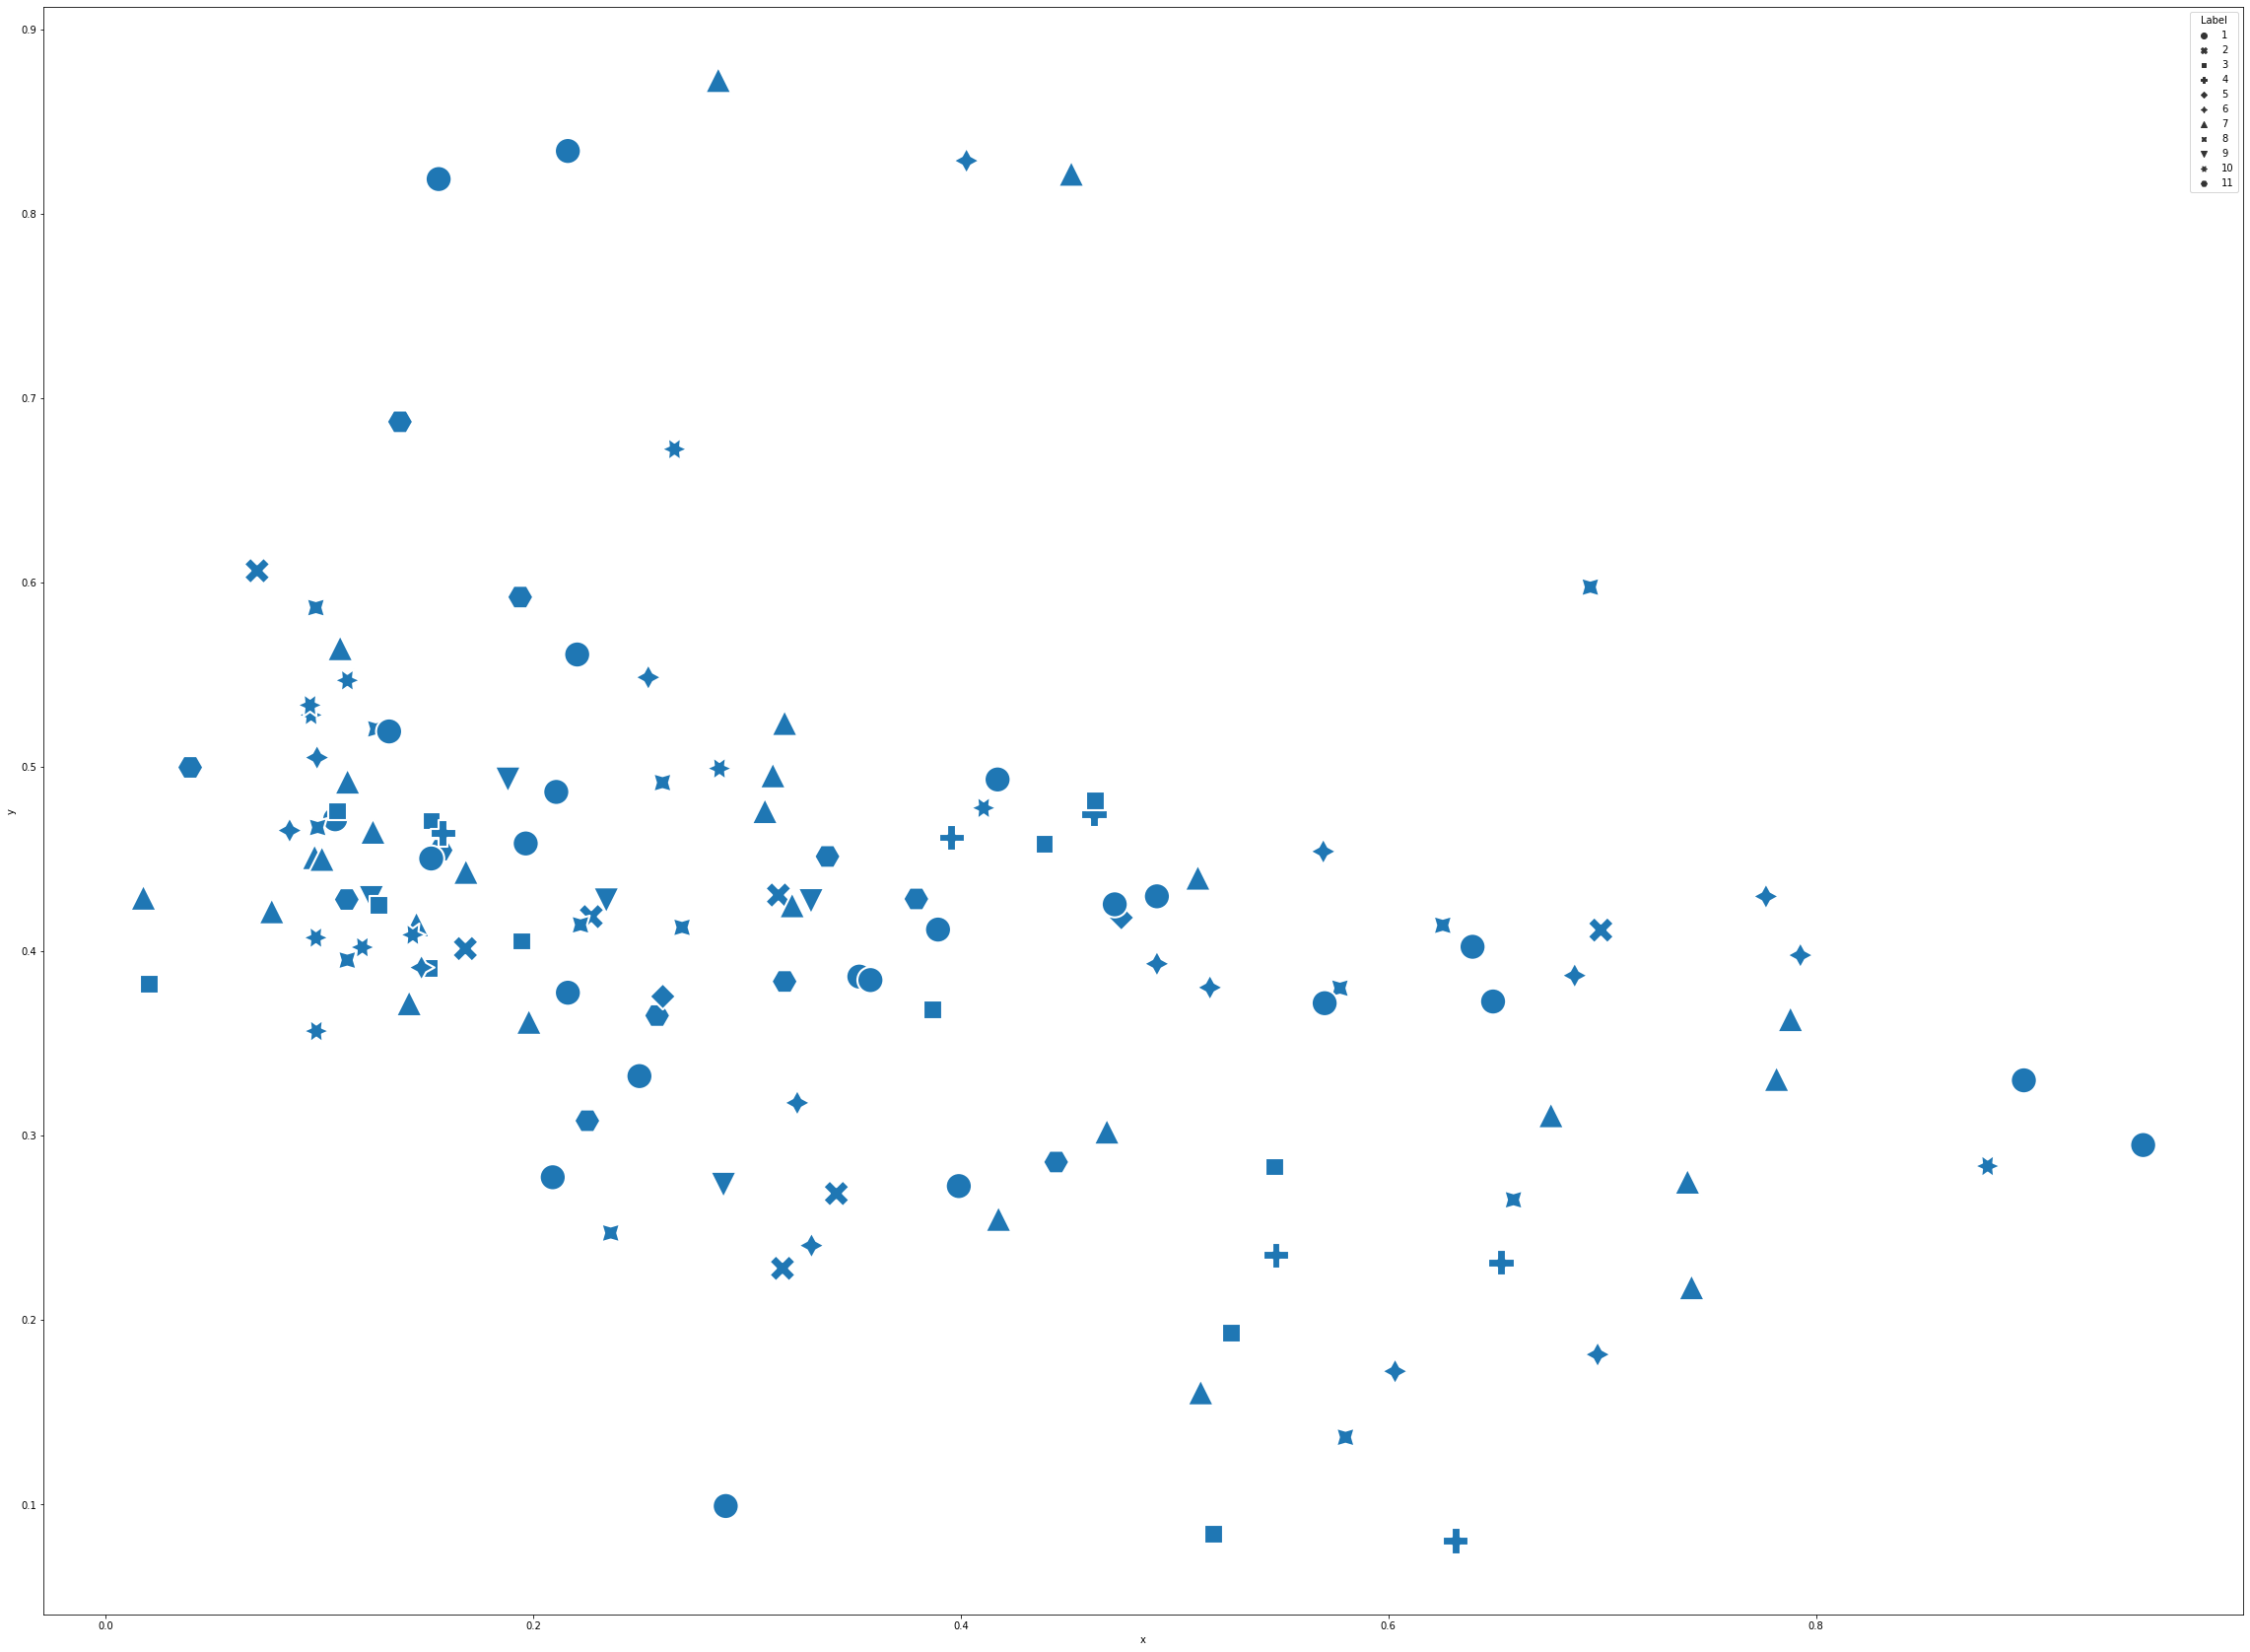

In [ ]:
fig = plt.figure()

ax = sns.scatterplot(x="x",y="y",data=df,style = "Label",s=700)

fig.set_size_inches(40,30)


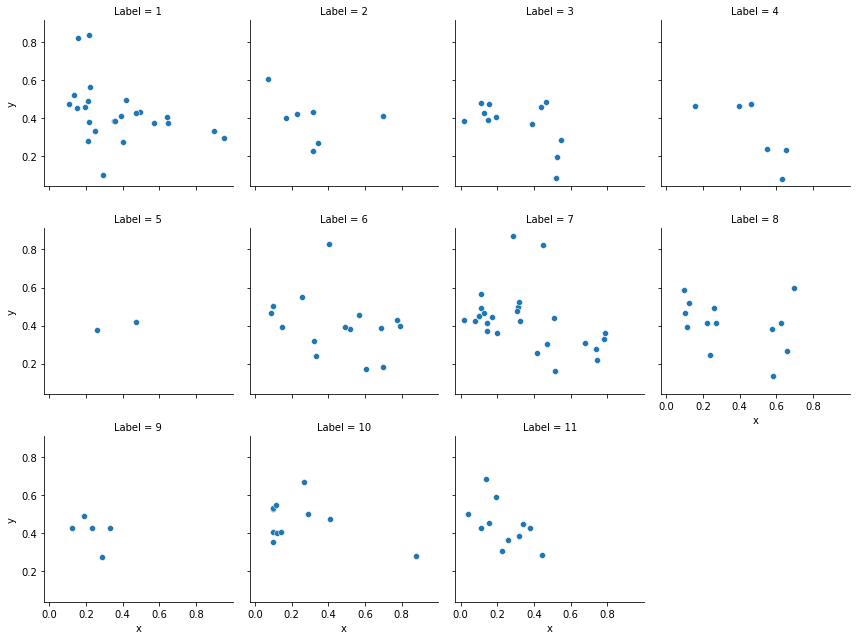

In [ ]:
grid = sns.FacetGrid(data=df, col = "Label",col_wrap=4)
grid.map(sns.scatterplot, "x", "y")

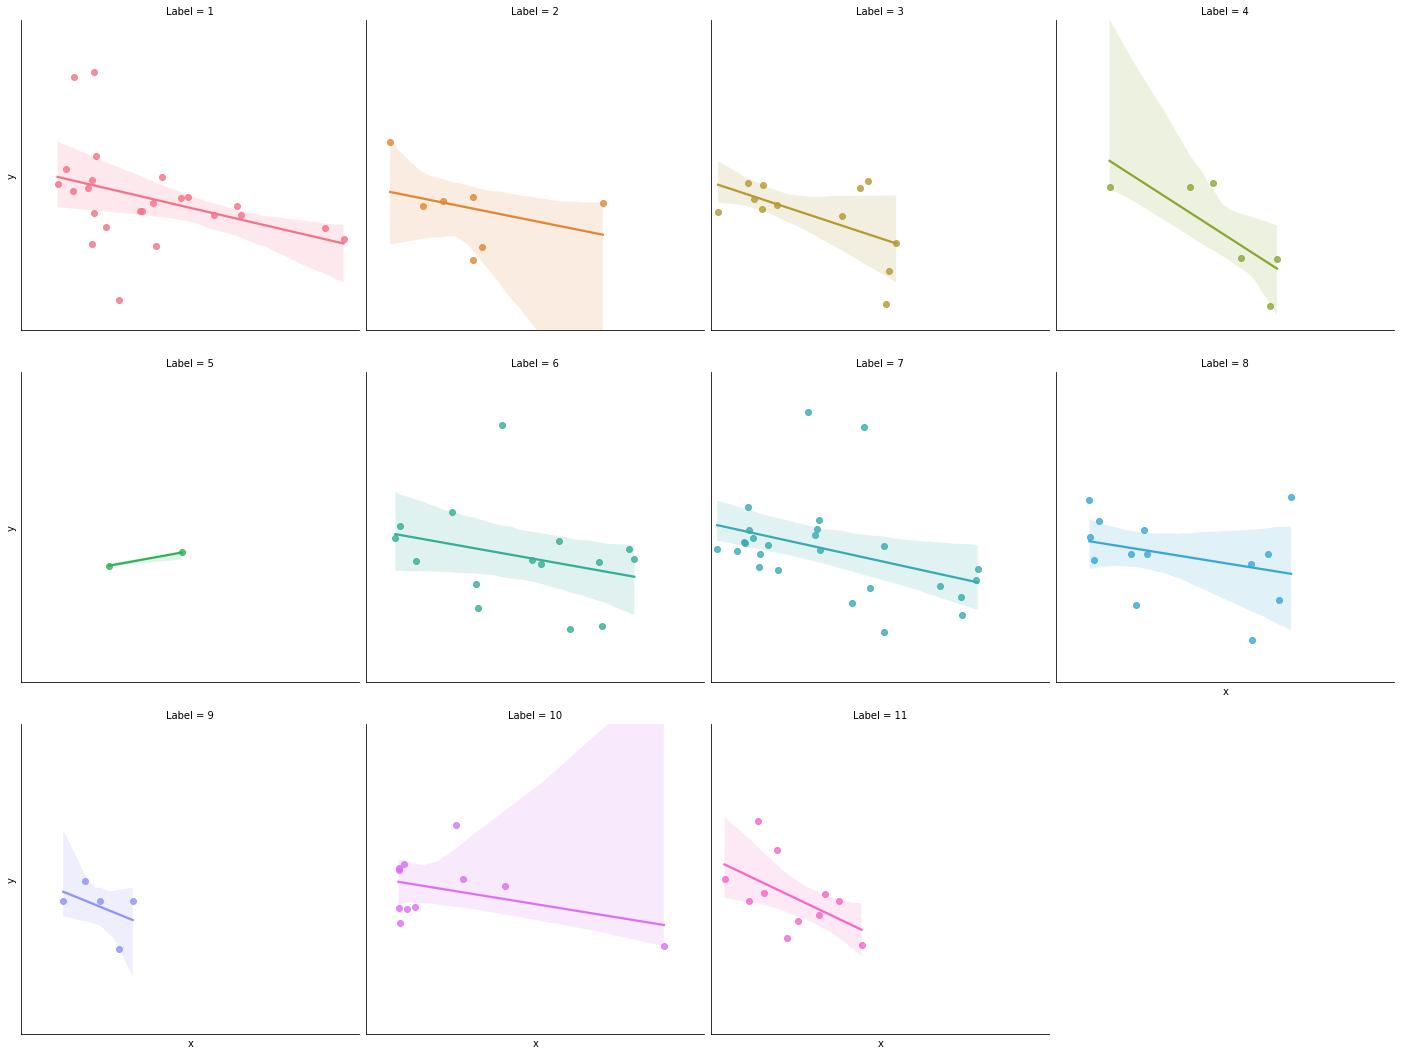

In [ ]:
g = sns.lmplot(x="x", y="y", col="Label", hue="Label",
               data=df, col_wrap=4)
g = (g.set_axis_labels()
      .set(xlim=(0, 1), ylim=(0, 1),
           xticks=[10, 30, 50], yticks=[2, 6, 10])
      .fig.subplots_adjust(wspace=.02))

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')